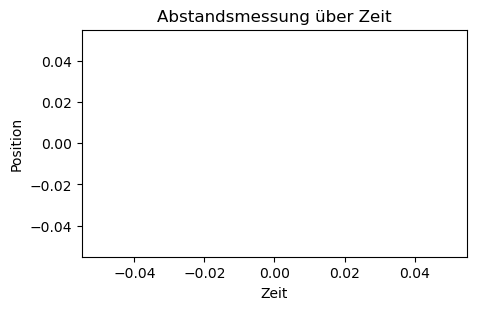

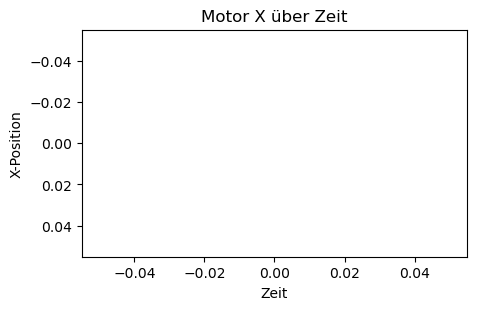

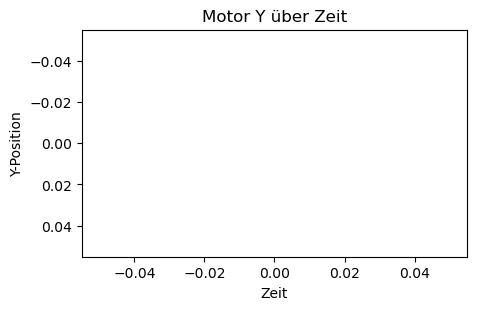

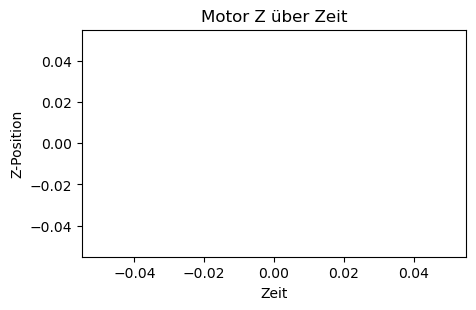

In [136]:
import tkinter as tk
import serial
import re
import threading
import queue
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# UART-Verbindung erstellen
ser = serial.Serial(
    'COM7',
    baudrate=115200,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_EVEN,
    stopbits=serial.STOPBITS_ONE,
    timeout=0.1  # kürzerer Timeout für Thread-Lesen
)

# Datenstrukturen
time_values = []
position_values = []
counter = 0

motor_x_history = []
motor_y_history = []
motor_z_history = []
motor_time = []         # gemeinsamer Zeitindex für Motor-Positionen
motor_x_time = []
motor_y_time = []
motor_z_time = []

motor_counter_x = 0
motor_counter_y = 0
motor_counter_z = 0      # Zähler für Motor-Datensätze


messung_aktiv = False
pos_aktiv     = False

# Queue für empfangene Zeilen
rx_queue = queue.Queue()

# Thread für kontinuierliches Lesen
def reader_thread():
    while True:
        try:
            raw = ser.readline()
            if raw:
                line = raw.decode("latin-1", errors="ignore").strip()
                rx_queue.put(line)
        except serial.SerialException:
            break

threading.Thread(target=reader_thread, daemon=True).start()

# GUI-Callbacks
def toggle_measurement(*args):
    global messung_aktiv
    if abstand_var.get():
        ser.write(b"M\r\n")
        messung_aktiv = True
    else:
        ser.write(b"MN\r\n")
        messung_aktiv = False
        ser.reset_input_buffer()

def send_text():
    z1 = text_line1.get().strip()
    z2 = text_line2.get().strip()
    if z1:
        ser.write(f"{z1}:Texto".encode())
        ser.write(b"\r\n")
    if z2:
        ser.write(f"{z2}:Textu".encode())
        ser.write(b"\r\n")
def toggle_ref(*args):
    if ref_var.get():
        ser.write(b"R\r\n")

def start_action():
    ser.write(b"START\r\n")
    
def stop_action():
    ser.write(b"STOP\r\n")

def toggle_pos(*args):
    global pos_aktiv
    if pos_var.get():
        ser.write(b"POS\r\n")
        pos_aktiv = True
    else:
        ser.write(b"NPOS\r\n")
        pos_aktiv = False
        ser.reset_input_buffer()

# Plot-Update-Funktion
def update_plots():
    # Abstandsmessung
    ax.clear()
    ax.plot(time_values, position_values, marker="x", linestyle="-", color="red")
    ax.set_title("Abstandsmessung über Zeit")
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Position")
    canvas.draw_idle()

    # Motor X vs Z
    ax_motor1.clear()
    ax_motor1.plot(motor_z_history, motor_x_history, 'o-', color="blue")
    ax_motor1.set_title("Motor X vs Motor Z")
    ax_motor1.set_xlabel("Motor Z")
    ax_motor1.set_ylabel("Motor X")
    ax_motor1.invert_yaxis()
    canvas_motor1.draw_idle()

    # Motor X vs Y
    ax_motor2.clear()
    ax_motor2.plot(motor_y_history, motor_x_history, 'o-', color="green")
    ax_motor2.set_title("Motor X vs Motor Y")
    ax_motor2.set_xlabel("Motor Y")
    ax_motor2.set_ylabel("Motor X")
    ax_motor2.invert_yaxis()
    canvas_motor2.draw_idle()
    
    # Motor X vs Zeit
    ax_mot_time_x.clear()
    ax_mot_time_x.plot(motor_time, motor_x_history, 'o-', color='purple')
    ax_mot_time_x.set_title("Motor X über Zeit")
    ax_mot_time_x.set_xlabel("Zeit")
    ax_mot_time_x.set_ylabel("X-Position")
    ax_mot_time_x.invert_yaxis()
    canvas_mot_time_x.draw_idle()
    
    # Motor Y vs Zeit
    ax_mot_time_y.clear()
    ax_mot_time_y.plot(motor_time, motor_y_history, 'o-', color='orange')
    ax_mot_time_y.set_title("Motor Y über Zeit")
    ax_mot_time_y.set_xlabel("Zeit")
    ax_mot_time_y.set_ylabel("Y-Position")
    ax_mot_time_y.invert_yaxis()
    canvas_mot_time_y.draw_idle()

    # Motor Z vs Zeit
    ax_mot_time_z.clear()
    ax_mot_time_z.plot(motor_time, motor_z_history, 'o-', color='brown')
    ax_mot_time_z.set_title("Motor Z über Zeit")
    ax_mot_time_z.set_xlabel("Zeit")
    ax_mot_time_z.set_ylabel("Z-Position")
    canvas_mot_time_z.draw_idle()


    # Nächstes Plot-Update
    root.after(200, update_plots)


def process_queue():
    global counter
    global motor_counter_x, motor_counter_y, motor_counter_z

    while not rx_queue.empty():
        line = rx_queue.get_nowait().strip()

        # Abstand ("123 mm")
        if messung_aktiv and "mm" in line:
            m = re.search(r"\d+", line)
            if m:
                d = int(m.group())
                time_values.append(counter)
                position_values.append(d)
                counter += 1
                # Motorposition
        elif pos_aktiv and line.startswith("X:"):
            m = re.search(r"X[:=]\s*(\d+)\s*Y[:=]\s*(\d+)\s*Z[:=]\s*(\d+)", line)
            if m:
                x, y, z = map(int, m.groups())
                motor_x_history.append(x)
                motor_y_history.append(y)
                motor_z_history.append(z)

        else:
            # alle anderen Zeilen (Debug/Unbekanntes)
            print(line)

    # alle 50 ms wieder aufrufen
    root.after(50, process_queue)

# Hauptfenster erstellen
root = tk.Tk()                              
root.title("Arduino Steuerung")

# Oberer Bereich für Checkboxen, Buttons u. Eingabefeld
top_frame = tk.Frame(root)
top_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)

# Checkbox für Referenzfahrt
ref_var = tk.BooleanVar()  # Variable für den Zustand der Referenzfahrt
ref_checkbox = tk.Checkbutton(top_frame, text="Referenzfahrt", variable=ref_var)
ref_checkbox.pack(side=tk.LEFT, padx=5)
ref_var.trace_add("write", toggle_ref)

# Checkbox für Abstand messen
abstand_var = tk.BooleanVar()  # Variable für die Abstandsmessung
abstand_checkbox = tk.Checkbutton(top_frame, text="Abstand messen", variable=abstand_var)
abstand_checkbox.pack(side=tk.LEFT, padx=5)
abstand_var.trace_add("write", toggle_measurement)

# Checkbox für Positionierung
pos_var = tk.BooleanVar()  # Variable für die Positionierung
pos_checkbox = tk.Checkbutton(top_frame, text="Positionierung", variable=pos_var)
pos_checkbox.pack(side=tk.LEFT, padx=5)
pos_var.trace_add("write", toggle_pos)

# Neues Frame für zweizeilige Eingabe
text_frame = tk.Frame(root)
text_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)

label1 = tk.Label(text_frame, text="Zeile 1:")
label1.pack(anchor="w")
text_line1 = tk.Entry(text_frame)
text_line1.pack(fill=tk.X, padx=5, pady=2)

label2 = tk.Label(text_frame, text="Zeile 2:")
label2.pack(anchor="w")
text_line2 = tk.Entry(text_frame)
text_line2.pack(fill=tk.X, padx=5, pady=2)

# Sende-Button separat platzieren
send_button = tk.Button(text_frame, text="Sende Text", command=send_text)
send_button.pack(pady=5)


# Buttons "Start" und "Not-Aus" in einem weiteren Frame
button_frame = tk.Frame(root)
button_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)

start_button = tk.Button(button_frame, text="Start", command=start_action)
start_button.pack(side=tk.LEFT, padx=5)
stop_button = tk.Button(button_frame, text="Not-Aus", command=stop_action, bg="red", fg="white")
stop_button.pack(side=tk.LEFT, padx=5)

diagram_frame = tk.Frame(root)
diagram_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=10, pady=10)

# Grid-Konfiguration: eine Zeile, drei Spalten, alle gleich gewichtet
diagram_frame.grid_rowconfigure(0, weight=1)
for col in range(3):
    diagram_frame.grid_columnconfigure(col, weight=1)
diagram_frame.grid_rowconfigure(1, weight=1)   # nun auch 2. Zeile


# Diagramm 1: Abstandsmessung
fig, ax = plt.subplots()
canvas = FigureCanvasTkAgg(fig, master=diagram_frame)
widget1 = canvas.get_tk_widget()
widget1.grid(row=0, column=0, sticky="nsew", padx=5, pady=5)

# Diagramm 2: Motor X vs Motor Z
#fig_motor1, ax_motor1 = plt.subplots()
#canvas_motor1 = FigureCanvasTkAgg(fig_motor1, master=diagram_frame)
#widget2 = canvas_motor1.get_tk_widget()
#widget2.grid(row=0, column=1, sticky="nsew", padx=5, pady=5)

# Diagramm 3: Motor X vs Motor Y
#fig_motor2, ax_motor2 = plt.subplots()
#canvas_motor2 = FigureCanvasTkAgg(fig_motor2, master=diagram_frame)
#widget3 = canvas_motor2.get_tk_widget()
#widget3.grid(row=0, column=2, sticky="nsew", padx=5, pady=5)

# Diagramm 4: Motor X über Zeit
fig_mot_time_x, ax_mot_time_x = plt.subplots()
canvas_mot_time_x = FigureCanvasTkAgg(fig_mot_time_x, master=diagram_frame)
widget_mot_time_x = canvas_mot_time_x.get_tk_widget()
widget_mot_time_x.grid(row=1, column=0, sticky="nsew", padx=5, pady=5)

# Diagramm 5: Motor Y über Zeit
fig_mot_time_y, ax_mot_time_y = plt.subplots()
canvas_mot_time_y = FigureCanvasTkAgg(fig_mot_time_y, master=diagram_frame)
widget_mot_time_y = canvas_mot_time_y.get_tk_widget()
widget_mot_time_y.grid(row=1, column=1, sticky="nsew", padx=5, pady=5)

# Diagramm 6: Motor Z über Zeit
fig_mot_time_z, ax_mot_time_z = plt.subplots()
canvas_mot_time_z = FigureCanvasTkAgg(fig_mot_time_z, master=diagram_frame)
widget_mot_time_z = canvas_mot_time_z.get_tk_widget()
widget_mot_time_z.grid(row=1, column=2, sticky="nsew", padx=5, pady=5)



# Starte die Datenempfangsfunktion (wird alle 100 ms aufgerufen)
root.after(50, process_queue)
root.after(200, update_plots)

root.mainloop()
